In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install --no-index seaborn
!pip install --no-index scikit-learn


Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic/scikit_learn-1.5.0+computecanada-cp311-cp311-linux_x86_64.whl
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/threadpoolctl-3.5.0+computecanada-py3-none-any.whl (from scikit-learn)


In [3]:
import os 
parent = os.path.dirname(os.getcwd())
parent = os.path.dirname(parent)

print(f"{parent = }")


import sys
if not parent in sys.path:
    sys.path.append(parent)

parent = '/lustre06/project/6067616/soroush1/WM_age_of_ultron'


In [4]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

from torch.utils.data import DataLoader, random_split, Subset

import torch.optim as optim
from torchvision import models, transforms
from sklearn.model_selection import train_test_split

In [5]:
def plot_sequence_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, dataset.num_timesteps + 3 - 1, figsize=(15, 3*num_samples))
    
    for i in range(num_samples):
        sequence, label = dataset[np.random.randint(len(dataset))]
        for t in range(dataset.num_timesteps + 3 - 1):
            ax = axes[i, t]
            ax.imshow(sequence[t].permute(1, 2, 0))
            ax.axis('off')
            if t == 0:
                ax.set_title(f"Label: {list(dataset.label_to_idx.keys())[list(dataset.label_to_idx.values()).index(label)]}")
    
    plt.tight_layout()
    plt.show()

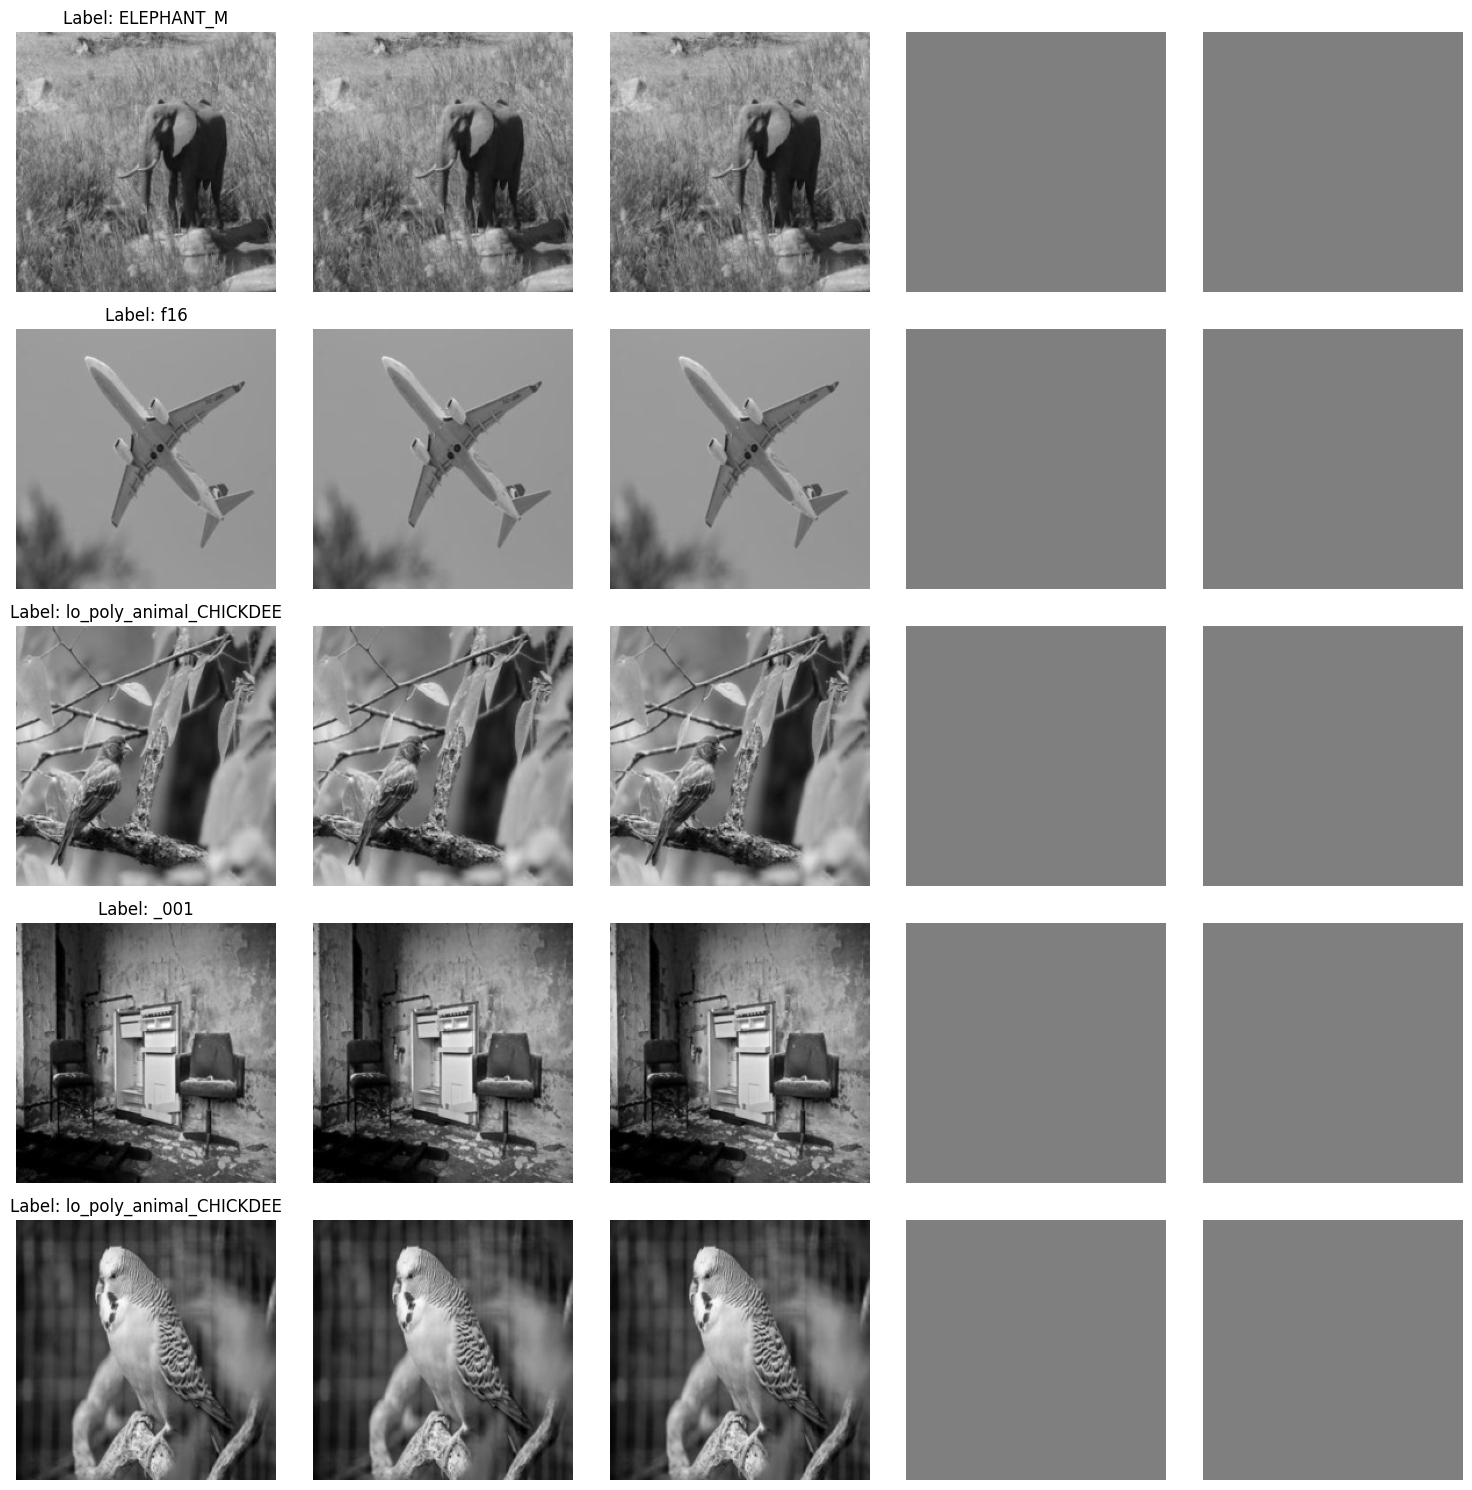

In [5]:
class Coco1600SequenceDataset(Dataset):
    def __init__(self, meta_file, img_dir, num_timesteps=5, transform=None):
        self.img_labels = pd.read_csv(meta_file)
        self.img_dir = img_dir
        self.num_timesteps = num_timesteps
        self.transform = transform
        self.to_grayscale = transforms.Grayscale(3)  # 3-channel grayscale
        
        # Create index map for object labels
        self.label_to_idx = {label: idx for idx, label in enumerate(self.img_labels['obj'].unique())}
    
    def __len__(self):
        return len(self.img_labels)

    def __coco1600_to_hvm200(self, label):

        coco1600_to_hvm200 = {
            "bear": "bear",
            "ELEPHANT_M": "elephant",
            "face0001": "person",
            "alfa155": "car",
            "breed_pug": "dog",
            "Apple_Fruit_obj": "apple",
            "_001": "chair",
            "f16": "plane",
            "lo_poly_animal_CHICKDEE": "bird",
            "zebra": "zebra"
        }
        
        return coco1600_to_hvm200[label]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.img_labels.iloc[idx]['image_names']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        label = self.img_labels.iloc[idx]['obj']
        label_idx = self.label_to_idx[label]
        
        # Create sequence: first frame is the original image, rest are grayscale
        sequence = [self.transform(image) if self.transform else transforms.ToTensor()(image) for _ in range(3)]
        for _ in range(self.num_timesteps - 1):
            # gray_value = torch.rand(1).item()
            gray_value = 0.5
            
            gray_frame = torch.full((3, 224, 224), gray_value)  # Assuming 224x224 is your image size
            sequence.append(gray_frame)
        
        sequence = torch.stack(sequence)
        return sequence, label_idx

# Example usage:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Grayscale(3),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
])

# Create the dataset
dataset = Coco1600SequenceDataset(meta_file='data/coco1600/coco1600_meta.csv',
                             img_dir='data/coco1600/images_cocogray',
                                     num_timesteps=3,
                             transform=transform)

# Plot some samples
plot_sequence_samples(dataset)

# Training Backbone (ResNet-50)

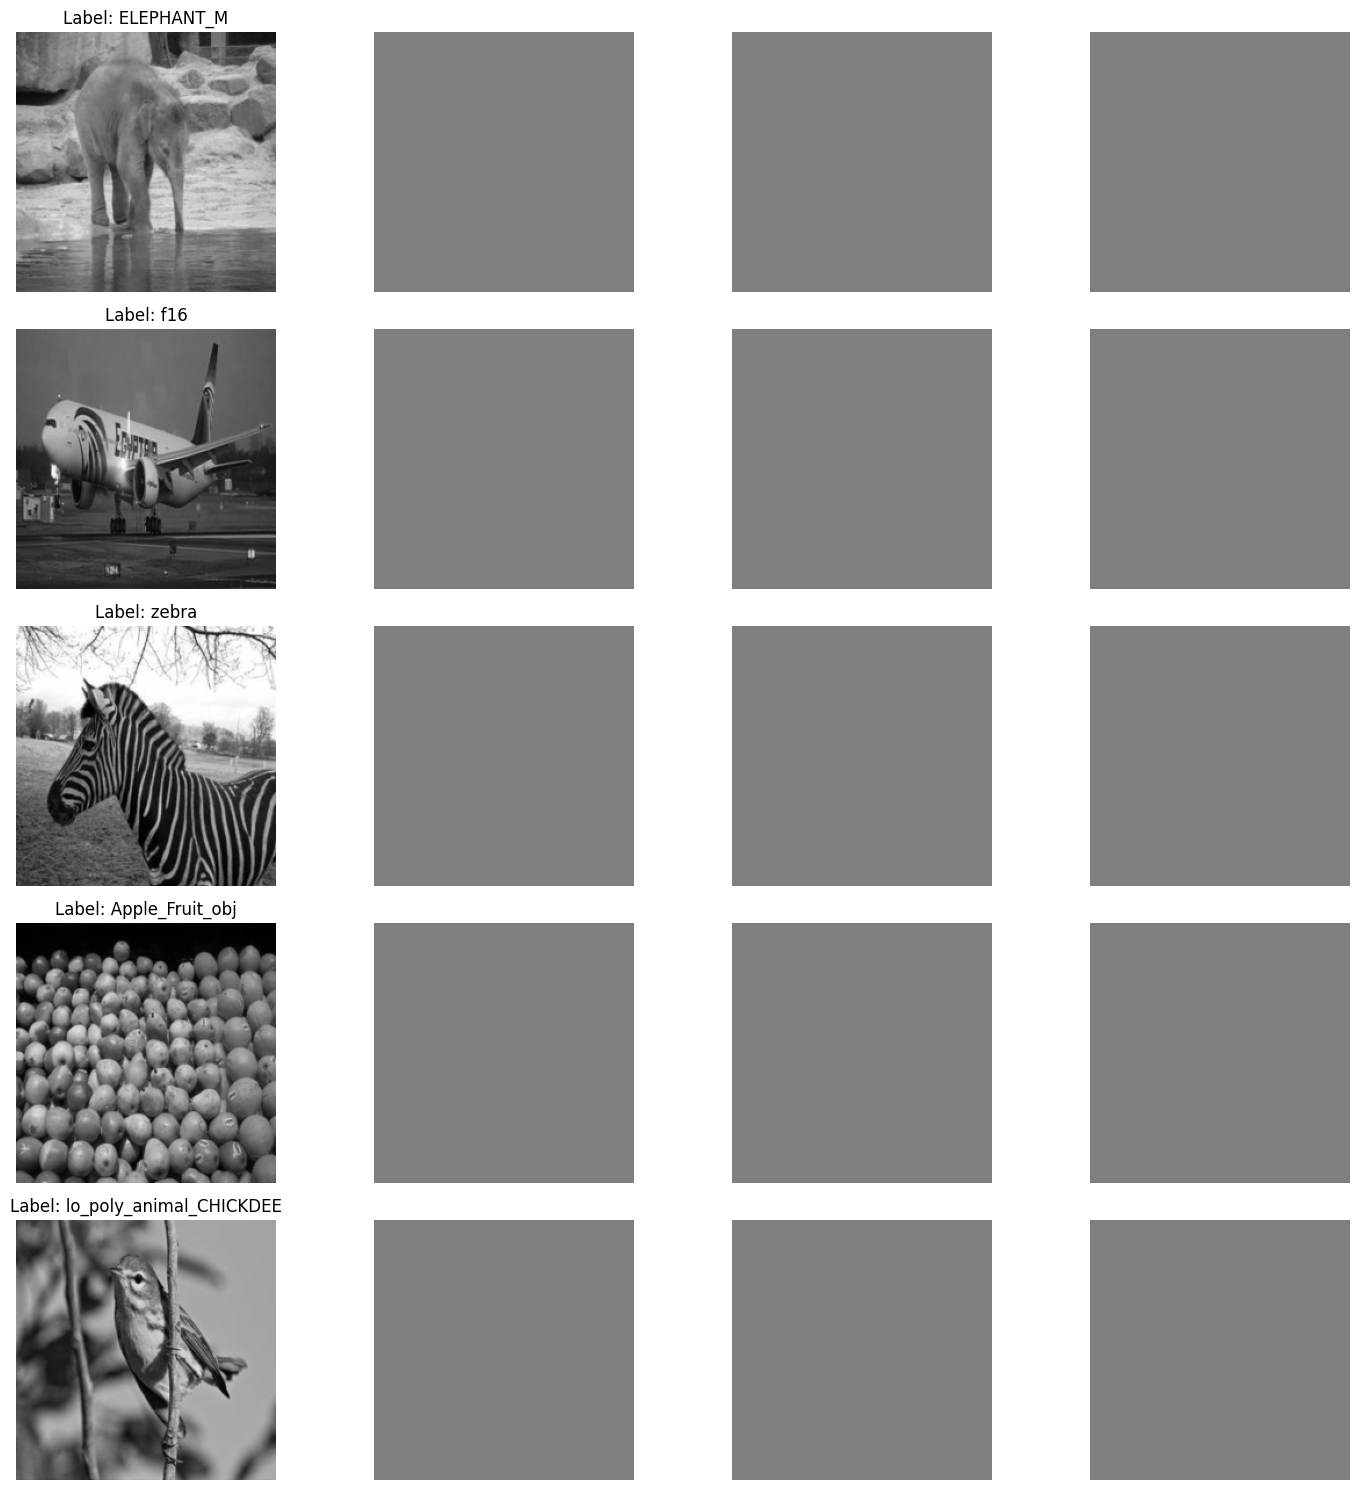

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

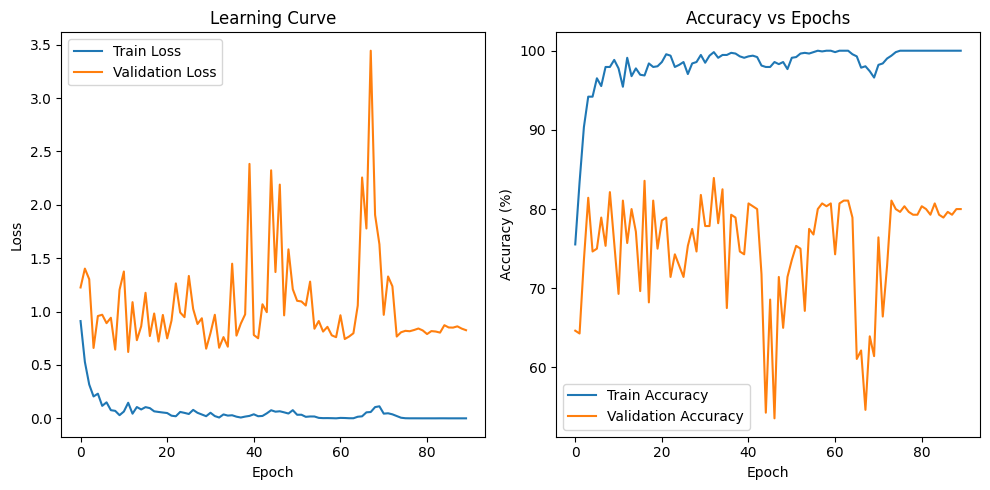

In [10]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 90
batch_size = 32
learning_rate = 0.001

# Example usage:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Grayscale(3),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
])

# Create the dataset
dataset = Coco1600SequenceDataset(meta_file='data/split_dataset/train_coco1600/coco1400_meta.csv',
                             img_dir='data/split_dataset/train_coco1600/images_cocogray',
                             num_timesteps=4,
                             transform=transform)

# Plot some samples
plot_sequence_samples(dataset)

# Split dataset into train and validation
# Split dataset while preserving label distribution
fraction = 0.8
train_indices, val_indices = train_test_split(
    range(len(dataset)),
    train_size=fraction,
    stratify=[dataset[i][1] for i in range(len(dataset))],
    random_state=42
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained ResNet50 and modify for binary classification and 1-channel input
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
print(f"{model}")

# Modify the final fully connected layer for binary classification
num_classes = len(dataset.label_to_idx)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)  # 2 classes: circle and square
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for sequences, labels in train_loader:
        # Get only the first frame (t=0)
        images = sequences[:, 0, :, :, :]
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for sequences, labels in val_loader:
            images = sequences[:, 0, :, :, :]
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

# Save model weights
torch.save(model.state_dict(), 'resnet50_finetuned_coco1400.pth')
print("Model weights saved to 'resnet50_finetuned_coco1400.pth'")

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.tight_layout()
plt.show()

## Test model on train dataset

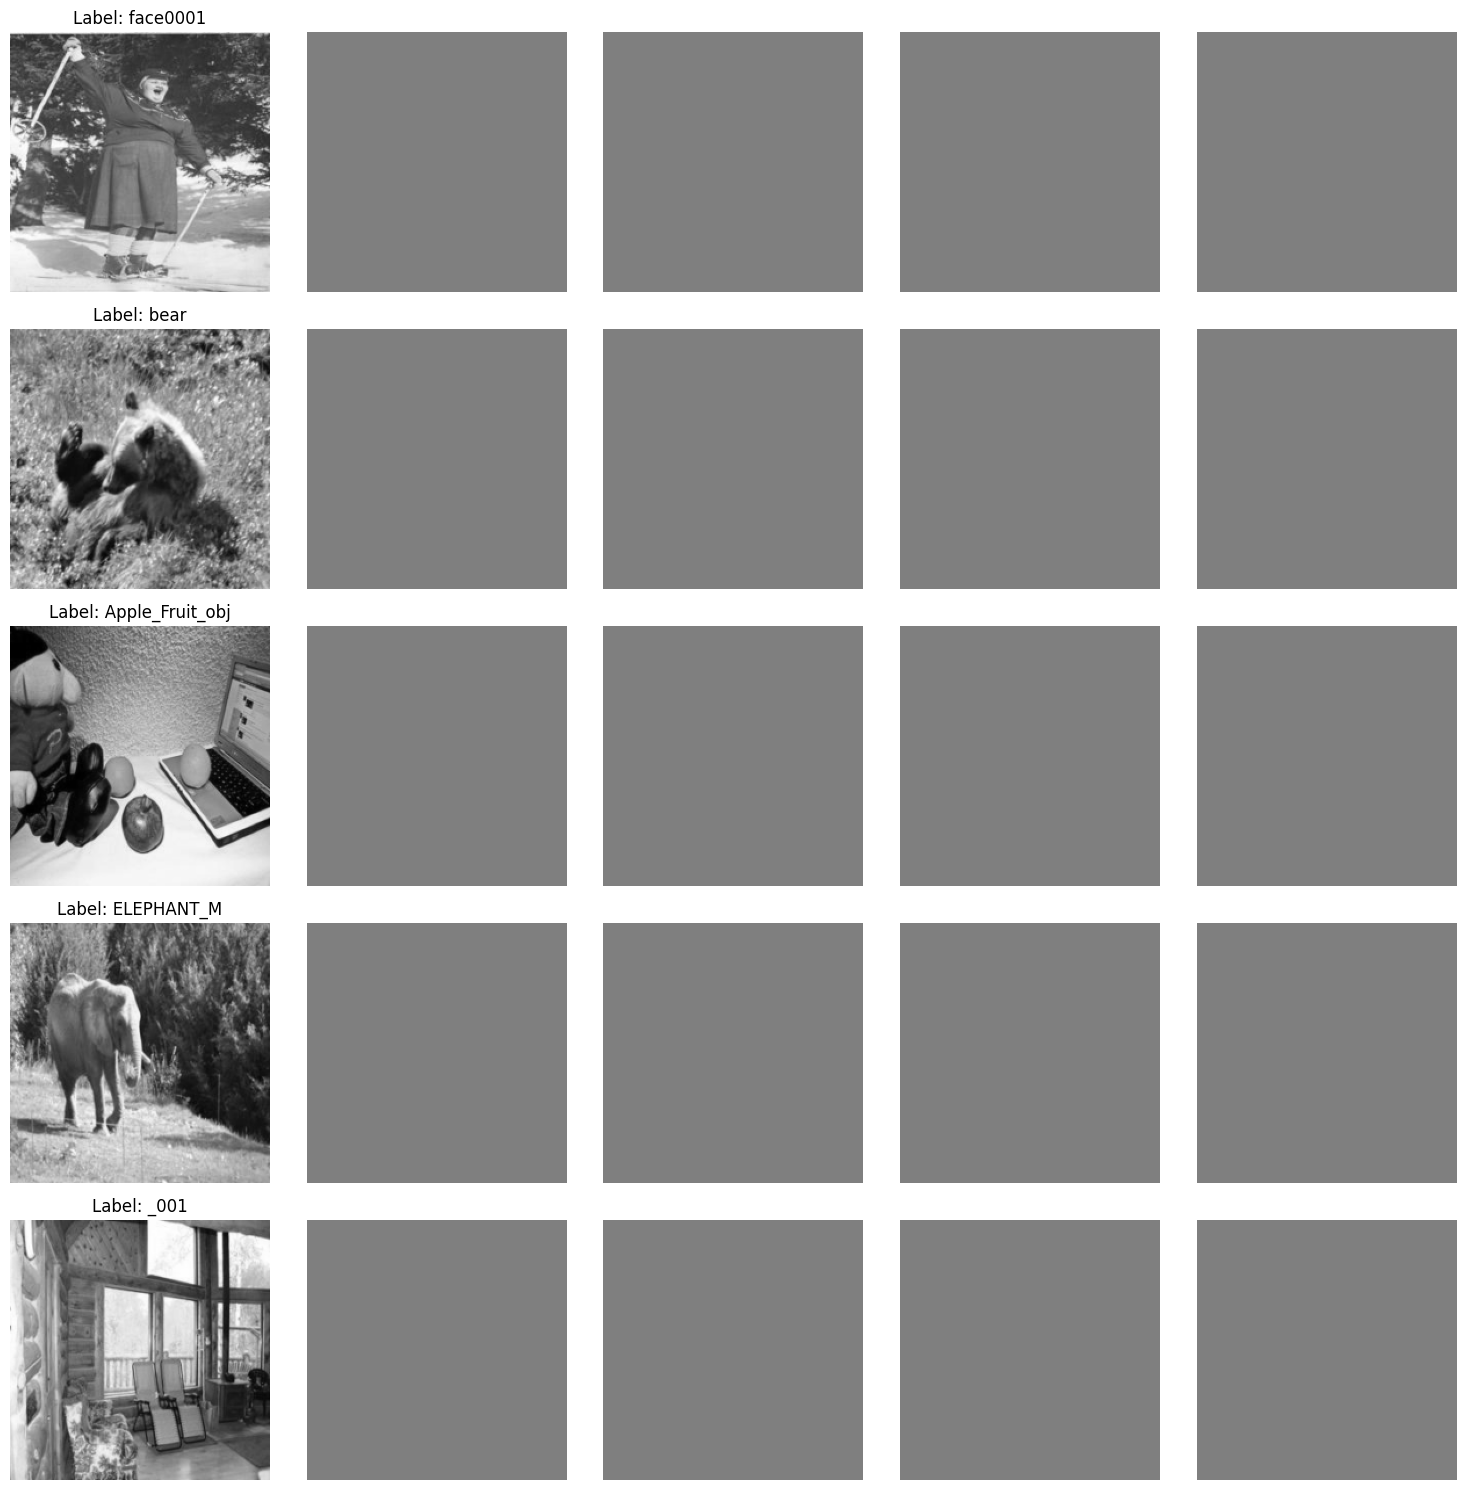

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 90
batch_size = 32
learning_rate = 0.001

# Example usage:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Grayscale(3),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
])

# Create the dataset
dataset = Coco1600SequenceDataset(meta_file='data/coco1600/coco1600_meta.csv',
                             img_dir='data/coco1600/images_cocogray',
                             num_timesteps=5,
                             transform=transform)

# Plot some samples
plot_sequence_samples(dataset)

# Create data loaders
dl_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load pre-trained ResNet50 and modify for binary classification and 1-channel input
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
print(f"{model}")

# Modify the final fully connected layer for binary classification
num_classes = len(dataset.label_to_idx)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)  # 2 classes: circle and square

model.load_state_dict(torch.load("resnet50_finetuned_coco1400.pth"))

model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Training loop
val_losses = []
val_accuracies = []

# Validation
model.eval()
val_loss = 0.0
val_correct = 0
val_total = 0

with torch.no_grad():
    for sequences, labels in dl_loader:
        images = sequences[:, 0, :, :, :]
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        _, predicted = outputs.max(1)
        val_total += labels.size(0)
        val_correct += predicted.eq(labels).sum().item()

val_loss /= len(dl_loader)
val_accuracy = 100. * val_correct / val_total
val_losses.append(val_loss)
val_accuracies.append(val_accuracy)

print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
print(f"{val_losses = }")
print(f"{val_accuracies = }")


# Train the LSTM part of the model

In [7]:
import torch
import torch.nn as nn
from torchvision import models

class ResNetLSTM(nn.Module):
    def __init__(self, num_classes, hidden_size=256, num_layers=1, dropout_rate=0.5):
        super(ResNetLSTM, self).__init__()
        
        # Load ResNet50 architecture (without weights)
        # self.resnet = models.resnet50(weights=None)
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
        
        # Load your fine-tuned weights
        # self.resnet.load_state_dict(torch.load('version1_analysis/resnet50_finetuned_coco1400.pth'))
        
        # Remove the final fully connected layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        
        # Freeze ResNet50 layers
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Get the number of features from the last layer of ResNet50
        self.resnet_out_features = 2048  # This is the number of features output by ResNet50

        self.dropout = nn.Dropout(dropout_rate)
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=self.resnet_out_features, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True)
        
        # Combine features
        self.combine_features = nn.Sequential(
            nn.Linear(self.resnet_out_features + hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Final classifier
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        
        # Extract features using ResNet50
        resnet_features = self.resnet(c_in)
        resnet_features = resnet_features.view(batch_size, timesteps, -1)

        # Apply dropout to ResNet features
        resnet_features = self.dropout(resnet_features)
        
        # Pass through LSTM
        lstm_out, (h_n, c_n) = self.lstm(resnet_features)
        # Apply dropout to LSTM output
        lstm_out = self.dropout(lstm_out)
        
        # Get the last output of LSTM
        lstm_last_out = lstm_out[:, -1, :]
        
        # Get the last ResNet features
        resnet_last_out = resnet_features[:, -1, :]
        
        # Combine LSTM and ResNet features
        combined = torch.cat((resnet_last_out, lstm_last_out), dim=1)
        # Apply dropout to combined features
        combined = self.dropout(combined)
        
        combined_features = self.combine_features(combined)
        # Apply dropout before final classification
        combined_features = self.dropout(combined_features)
        
        # Final classification
        output = self.classifier(combined_features)
        
        return output

# Usage example:
num_classes = 10  # Adjust based on your dataset
model = ResNetLSTM(num_classes)

# If you want to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print model summary
print(model)

# Example input
batch_size = 4
timesteps = 5
channels = 3
height = 224
width = 224
example_input = torch.randn(batch_size, timesteps, channels, height, width).to(device)
output = model(example_input)
print(f"Output shape: {output.shape}")

ResNetLSTM(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

## Train on 100ms delay 

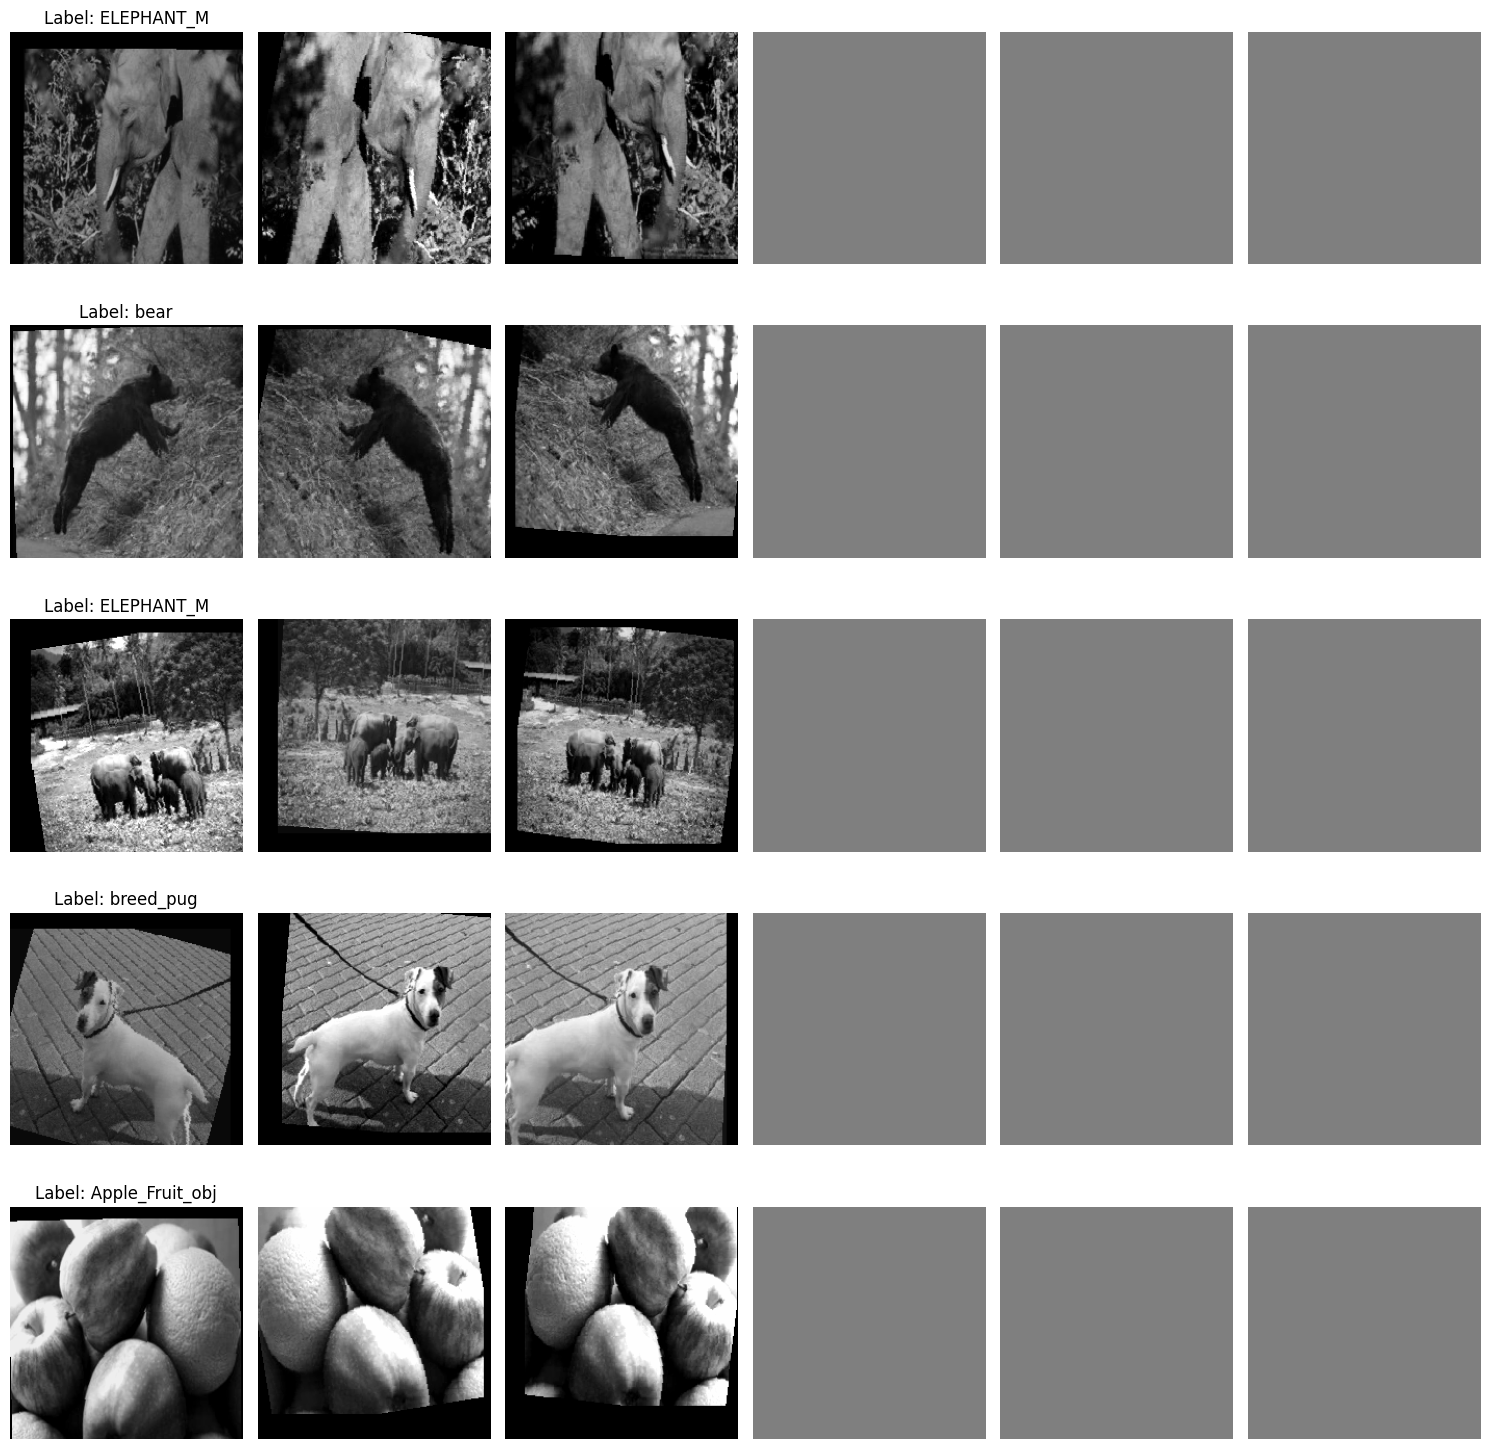

/localscratch/soroush1.36198325.0/env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/150], Train Loss: 2.3310, Train Acc: 9.64%, Val Loss: 2.3029, Val Acc: 10.00%
Epoch [2/150], Train Loss: 2.2060, Train Acc: 16.79%, Val Loss: 1.8256, Val Acc: 30.71%
Epoch [3/150], Train Loss: 1.5479, Train Acc: 42.95%, Val Loss: 1.1154, Val Acc: 52.86%
Epoch [4/150], Train Loss: 1.2452, Train Acc: 54.82%, Val Loss: 0.8322, Val Acc: 66.79%
Epoch [5/150], Train Loss: 1.0192, Train Acc: 64.46%, Val Loss: 0.7136, Val Acc: 77.50%
Epoch [6/150], Train Loss: 0.9066, Train Acc: 68.39%, Val Loss: 0.5882, Val Acc: 80.36%
Epoch [7/150], Train Loss: 0.7981, Train Acc: 76.34%, Val Loss: 0.6109, Val Acc: 83.93%
Epoch [8/150], Train Loss: 0.7710, Train Acc: 78.75%, Val Loss: 0.5312, Val Acc: 83.93%
Epoch [9/150], Train Loss: 0.7214, Train Acc: 77.86%, Val Loss: 0.5295, Val Acc: 83.57%
Epoch [10/150], Train Loss: 0.7196, Train Acc: 78.57%, Val Loss: 0.5237, Val Acc: 86.07%
Epoch [11/150], Train Loss: 0.6635, Train Acc: 80.27%, Val Loss: 0.4653, Val Acc: 86.43%
Epoch [12/150], Train Loss: 0.7

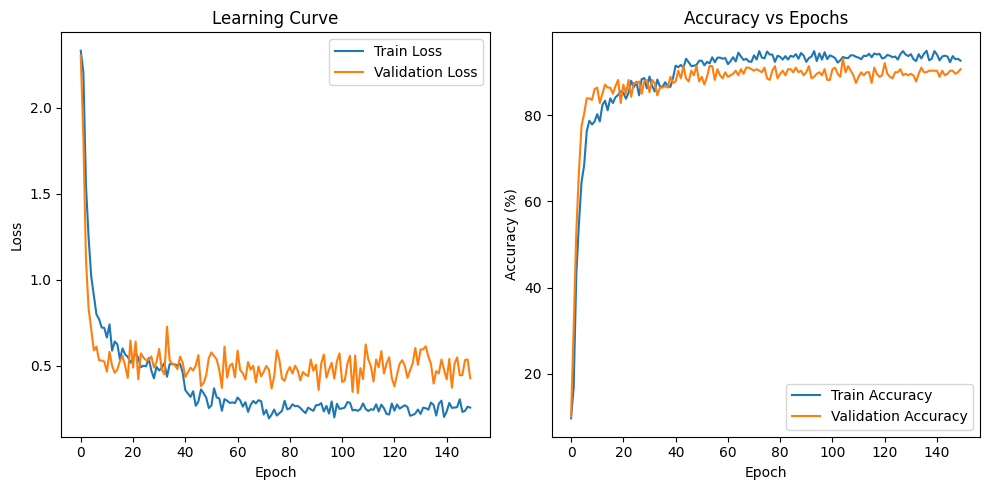

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Assuming you have these custom modules imported
# from your_dataset_module import Coco1600SequenceDataset
# from your_model_module import ResNetLSTM
# from your_utils_module import plot_sequence_samples

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 150
batch_size = 16
learning_rate = 0.001
num_timesteps = 4  # Delay 100ms
patience = 50  # for early stopping
factor = 0.1  # for learning rate scheduler

# Example usage:
transform = transforms.Compose([
       transforms.Resize((224, 224)),
       transforms.RandomHorizontalFlip(),
       transforms.RandomRotation(15),
       transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
       transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
       transforms.ToTensor(),
       transforms.Grayscale(3),
       transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
   ])

# Create the dataset
dataset = Coco1600SequenceDataset(meta_file='data/split_dataset/train_coco1600/coco1400_meta.csv',
                             img_dir='data/split_dataset/train_coco1600/images_cocogray',
                             num_timesteps=num_timesteps,
                             transform=transform)

# Plot some samples
plot_sequence_samples(dataset)

# Split dataset while preserving label distribution
fraction = 0.8
train_indices, val_indices = train_test_split(
    range(len(dataset)),
    train_size=fraction,
    stratify=[dataset[i][1] for i in range(len(dataset))],
    random_state=42
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create the model
num_classes = 10  # Adjust based on your dataset
model = ResNetLSTM(num_classes)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=15, verbose=True)

# Early stopping setup
best_val_loss = float('inf')
early_stopping_counter = 0

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences, labels = sequences.to(device), labels.to(device)

            outputs = model(sequences)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Learning rate scheduler step
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'resnetPytorch_lstm_finetuned_100ms_delay_coco1400_100ms_object_best.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

# Save final model weights
torch.save(model.state_dict(), 'resnetPytorch_lstm_finetuned_100ms_delay_coco1400_100ms_object_last.pth')
print("Final model weights saved to 'resnetPytorch_lstm_finetuned_100ms_delay_coco1400_100ms_object_last.pth'")

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.tight_layout()
plt.show()

## Find tune on HVM200

In [7]:
def extract_number(filename):
    # Extract the number from the filename
    match = re.search(r'im(\d+)\.png', filename)
    if match:
        return int(match.group(1))
    return 0  # Return 0 if no number is found

def sort_filenames(filenames):
    # Sort the filenames based on the extracted number
    return sorted(filenames, key=extract_number)

class HVM200SequenceDataset(Dataset):
    def __init__(self, image_path, num_timesteps=5, transform=None):
        self.image_path = image_path
        self.num_timesteps = num_timesteps
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        
        # Sort image files
        self.images = sort_filenames(glob(os.path.join(image_path, "*.png")))
        
        # Load metadata
        meta_data_path = os.path.join(image_path, "working_memory_images_labels.csv")
        self.meta_data = pd.read_csv(meta_data_path)
        self.meta_data["img_path"] = self.images
        
        # Create a mapping of unique objects to integer labels
        self.label_to_idx = {obj: i for i, obj in enumerate(self.meta_data["object"].unique())}
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Create sequence: first frame is the original image, rest are grayscale
        sequence = [self.transform(image)]
        for _ in range(self.num_timesteps - 1):
            gray_value = 0.5
            gray_frame = torch.full((3, 224, 224), gray_value)
            sequence.append(gray_frame)
        
        sequence = torch.stack(sequence)
        
        label = self.meta_data.loc[self.meta_data["img_path"] == img_path, "object"].values[0]
        label_idx = self.label_to_idx[label]
        
        return sequence, label_idx
    
    def hvm200_to_coco1600(self, label):
        hvm200_to_coco1600 = {
            "bear": "bear",
            "elephant": "ELEPHANT_M",
            "person": "face0001",
            "car": "alfa155",
            "dog": "breed_pug",
            "apple": "Apple_Fruit_obj",
            "chair": "_001",
            "plane": "f16",
            "bird": "lo_poly_animal_CHICKDEE",
            "zebra": "zebra"
        }
        return hvm200_to_coco1600.get(label, label)

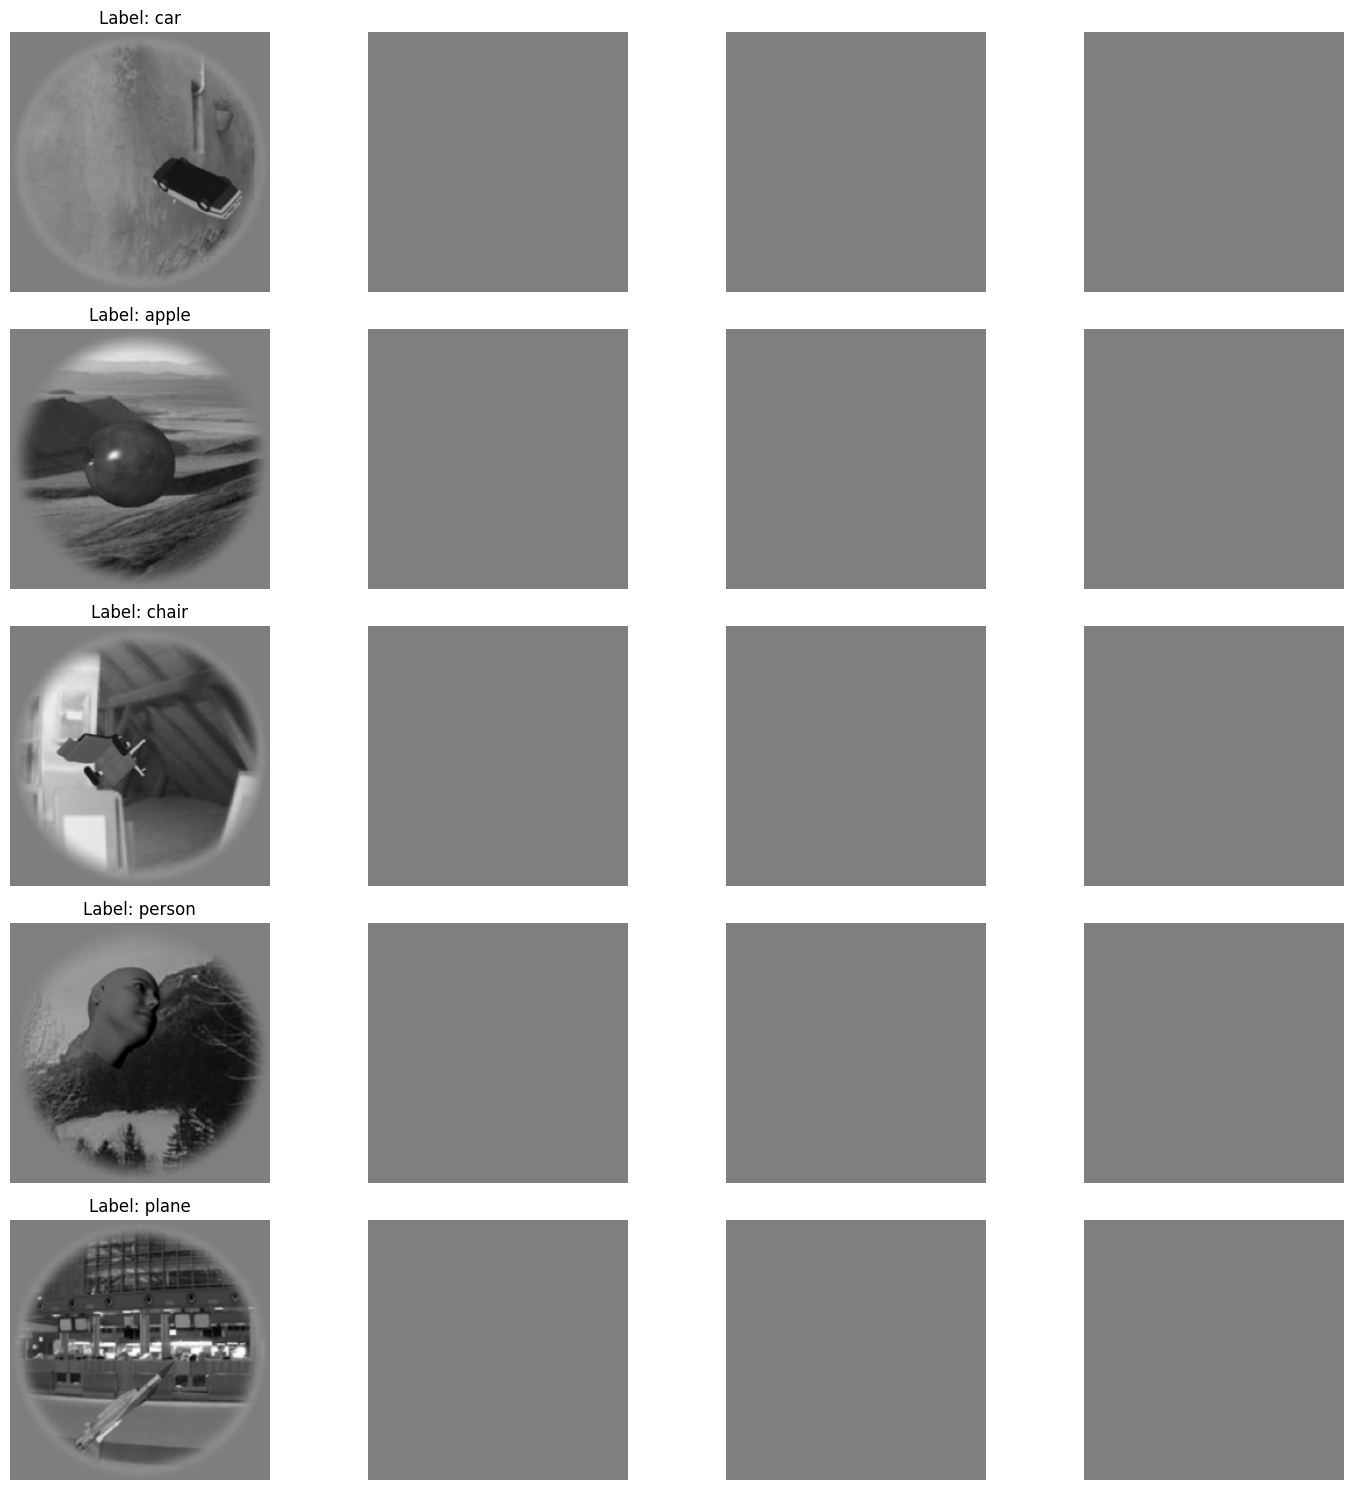

Test subset saved to 'test_subset.joblib'


/localscratch/soroush1.36135197.0/env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/150], Train Loss: 2.3202, Train Acc: 6.00%, Test Loss: 2.3007, Test Acc: 10.00%
Epoch [2/150], Train Loss: 2.3130, Train Acc: 2.00%, Test Loss: 2.2998, Test Acc: 10.00%
Epoch [3/150], Train Loss: 2.2937, Train Acc: 9.00%, Test Loss: 2.2914, Test Acc: 13.00%
Epoch [4/150], Train Loss: 2.2330, Train Acc: 17.00%, Test Loss: 2.3142, Test Acc: 10.00%
Epoch [5/150], Train Loss: 2.2040, Train Acc: 19.00%, Test Loss: 2.4536, Test Acc: 12.00%
Epoch [6/150], Train Loss: 2.1458, Train Acc: 17.00%, Test Loss: 2.3683, Test Acc: 11.00%
Epoch [7/150], Train Loss: 2.0493, Train Acc: 21.00%, Test Loss: 2.4431, Test Acc: 13.00%
Epoch [8/150], Train Loss: 2.0752, Train Acc: 18.00%, Test Loss: 2.6457, Test Acc: 14.00%
Epoch [9/150], Train Loss: 1.9062, Train Acc: 25.00%, Test Loss: 2.6695, Test Acc: 17.00%
Epoch [10/150], Train Loss: 1.9606, Train Acc: 27.00%, Test Loss: 2.6738, Test Acc: 14.00%
Epoch [11/150], Train Loss: 1.8979, Train Acc: 27.00%, Test Loss: 2.7871, Test Acc: 9.00%
Epoch [12/15

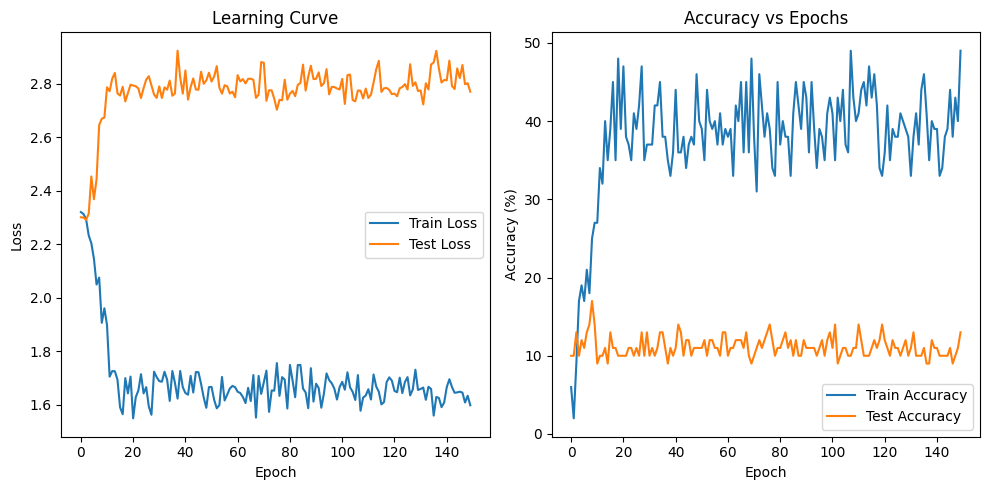

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import joblib
from glob import glob
import re
import random

# Assuming you have these custom modules imported
# from your_dataset_module import HVM200SequenceDataset
# from your_model_module import ResNetLSTM
# from your_utils_module import plot_sequence_samples

# Set device and seed for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
random.seed(42)

# Hyperparameters
num_epochs = 150
batch_size = 8
learning_rate = 0.001
num_timesteps = 4  # Delay 100ms
patience = 10  # for early stopping
factor = 0.1  # for learning rate scheduler

# Data augmentation transforms
def augment_first_frame(sequence):
    # Define augmentation transforms
    augment_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    ])
    
    # Apply augmentation only to the first frame
    augmented_first_frame = augment_transform(sequence[0])
    
    # Replace the first frame with the augmented version
    augmented_sequence = torch.cat([augmented_first_frame.unsqueeze(0), sequence[1:]], dim=0)
    
    return augmented_sequence

class AugmentedHVM200SequenceDataset(HVM200SequenceDataset):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.is_train = True

    def __getitem__(self, index):
        sequence, label = super().__getitem__(index)
        if self.is_train:
            return augment_first_frame(sequence), label
        else:
            return sequence, label

# Create the dataset
image_path = "data/hvm200/"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Grayscale(3),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
])

dataset = HVM200SequenceDataset(image_path, num_timesteps=num_timesteps, transform=transform)

# Plot some samples
plot_sequence_samples(dataset)

# Split dataset into train (50%) and test (50%) while preserving label distribution
train_size = 0.5
train_indices, test_indices = train_test_split(
    range(len(dataset)),
    train_size=train_size,
    stratify=[dataset[i][1] for i in range(len(dataset))],
    random_state=42
)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Disable augmentation for the test set
dataset.is_train = False

# Save the test subset object
joblib.dump(test_dataset, 'test_subset.joblib')
print("Test subset saved to 'test_subset.joblib'")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create the model
num_classes = 10  # Adjust based on your dataset
model = ResNetLSTM(num_classes)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=5, verbose=True)

# Early stopping setup
best_test_loss = float('inf')
early_stopping_counter = 0

# Training loop
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # Enable augmentation for training
    dataset.is_train = True
    
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100. * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Disable augmentation for testing
    dataset.is_train = False
    
    # Test
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)

            outputs = model(sequences)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

    # Learning rate scheduler step
    scheduler.step(test_loss)

    # # Early stopping check
    # if test_loss < best_test_loss:
    #     best_test_loss = test_loss
    #     early_stopping_counter = 0
    #     # Save the best model
    #     torch.save(model.state_dict(), 'resnetlstm_finetuned_100ms_delay_hvm200_best.pth')
    # else:
    #     early_stopping_counter += 1
    #     if early_stopping_counter >= patience:
    #         print(f"Early stopping triggered after {epoch+1} epochs")
    #         break

# Save final model weights
torch.save(model.state_dict(), 'resnetlstm_finetuned_100ms_delay_hvm200_final.pth')
print("Final model weights saved to 'resnetlstm_finetuned_100ms_delay_hvm200_final.pth'")

# Plot learning curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.tight_layout()
plt.savefig('training_results_first_frame_augmented.png')
plt.show()